<img src="logo.png"/>

# PSF Modelling
In this notebook we will go through the theory of PSF modelling and build a series of functitons to help calculate PSFs in the future.

We have already seen how the PSF of a system can be calculated from the Fourier transform of the apperture function.
However, although this is a good approximation in image processing, in the real world more complicated models are needed. For a correct model of focussing through a high NA lens we must consider the effects of phase distortions on the beam as well as the polarisation of the input light. The frist step is to redefine the beam as a composition of electrical fields with orthogonal polrasation states. These can ten be recombined later to give the final electric field.
The next step is to further break up the electric field into an infinite sum of waves travelling through different positions in the  aperture, i.e. the electric field at the focus is calculated by integrating over all possible waves reaching it. As the beam is radially symmetric around the optical axis, the integral is usually taken over the solid angle of the lens. This then becomes a double integral over the radial coordinate $\phi $ and the acceptance angle of the lens $ \theta $    
 <img src="Debeye Integral Co-ordinates.jpg" alt="drawing" width="400"/>
 
 
Without going into the original derivation by Richards and Wolf, we can calculate the PSF using: 

$$ \textbf{E}(x,y,z) = \frac{ikC}{2\pi} \iint_{\Omega} \textbf{T}(S)\exp(ik[(\Phi(x,y)+) d\Omega$$



We can begin in the same as we did before; by defining a circular pupil.

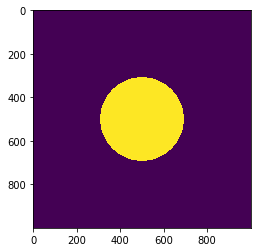

In [1]:
import numpy as np
import skimage
from skimage import io
from matplotlib import pyplot as plt

w = 1000 # Number of pixels
wave = 500 # Wavelength (nm)
px = 80 # Pixel size (nm)
NA = 1.2 # Objective numerical aperture 

dkxy = (2*np.pi)/(w*px)

# define the coordiante matrices we will need
x = np.linspace(-w/2,w/2,w)
y = np.linspace(-w/2,w/2,w)
X,Y = np.meshgrid(x,y)
R = np.sqrt(X**2+Y**2)

# Determine the coefficients form the constants
dkxy = (2*np.pi)/(w*px)
kMax = (2*np.pi*NA)/(wave*dkxy)

# And then draw the basic pupil
pupil = np.zeros((w,w))
pupil[R<kMax] = 1

plt.imshow(pupil)
plt.show()


But, as we work with higher numerical aperture objectives, we can no longer model the pupil as a uniform circle. 

 <img src="Debeye Integral Co-ordinates.jpg" alt="drawing" width="600"/>